# SOLUTION 1: Try to define quantifiers 

In [2]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy
from skimage.filters import threshold_otsu,sobel,sobel_v,sobel_h 
from scipy import ndimage
import os
from os import listdir
from os.path import isfile, join
from PIL import Image
from scipy import io
dirname = os.getcwd()
dirname = os.path.join(dirname,'..','data','duke2D')
path_normal = os.path.join(dirname,'normal')
path_amd = os.path.join(dirname,'amd')

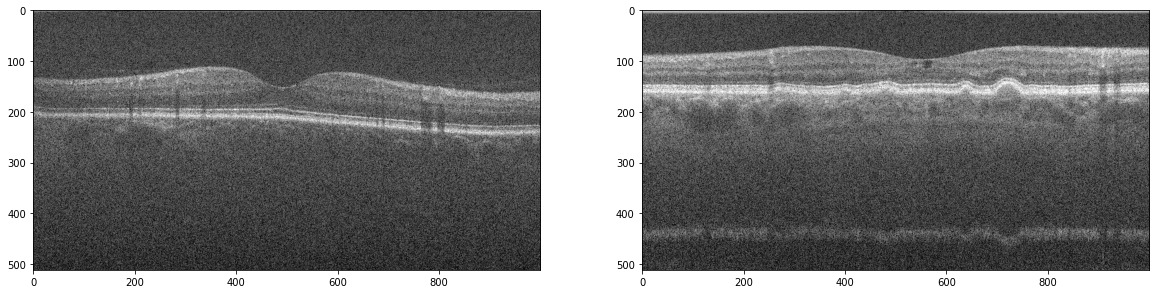

In [300]:
files_normal = [f for f in listdir(path_normal) if isfile(join(path_normal, f))]
files_amd = [f for f in listdir(path_amd) if isfile(join(path_amd, f))]
image_name_normal = files_normal[0]
image_name_amd = files_amd[0]
image_normal = mpimg.imread(os.path.join(path_normal,image_name_normal))
image_amd = mpimg.imread(os.path.join(path_amd,image_name_amd))
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(image_normal,cmap="gray")
plt.subplot(122)
plt.imshow(image_amd,cmap="gray")

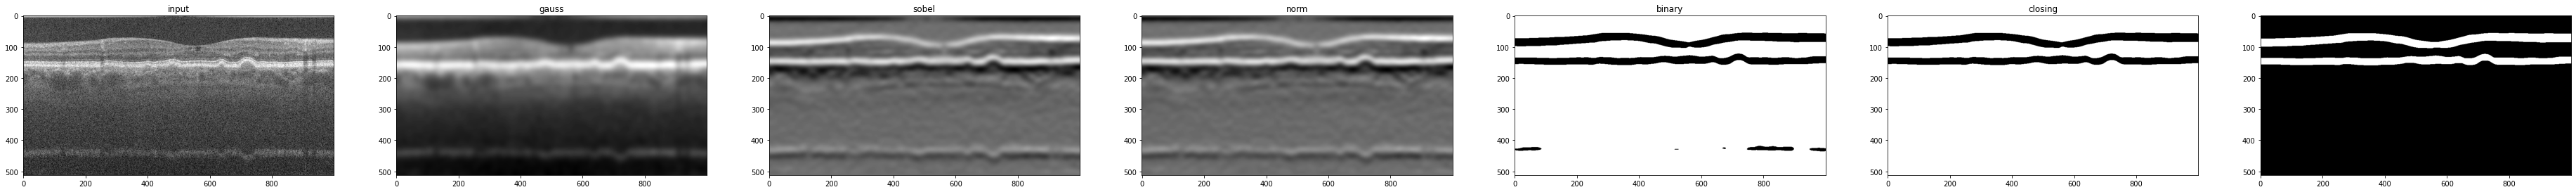

In [301]:
from scipy import ndimage
from scipy import signal
import skimage.filters as skifilt
import skimage.segmentation as skiseg
import skimage.morphology as skimorph
import cv2

input=image_amd # image_normal image_amd

# K=gaussian_kernel_xy(size=21, sigmax=8, sigmay=11)
# K=gaussian_kernel(size=20, sigma=11)
# i_gauss = ndimage.filters.convolve(input, K)
i_gauss = ndimage.gaussian_filter(input,sigma=9)

i_sobel_v=scipy.ndimage.sobel(i_gauss, axis=0, output=None, mode='reflect', cval=0.0)
i_sobel_h=scipy.ndimage.sobel(i_gauss, axis=1, output=None, mode='reflect', cval=0.0)

i_sobel=i_sobel_v #+i_sobel_h**2
i_normalized = (i_sobel-np.min(i_sobel))/(np.max(i_sobel)-np.min(i_sobel))
tho = skifilt.threshold_otsu(i_normalized)
i_bw = i_normalized<tho
i_rh = skimorph.remove_small_holes(i_bw,area_threshold=4000)

kernel = np.ones((20,20),np.uint8)
i_rh_8 = np.array(1-i_rh, dtype=np.uint8)
i_closing = cv2.morphologyEx(i_rh_8, op=cv2.MORPH_CLOSE,kernel=kernel)
# i_dil=skimorph.area_closing(i_rh,area_threshold=50000)

fig,ax = plt.subplots(1,7,figsize=(65,5))
ax[0].imshow(input,cmap='gray');		ax[0].set_title("input")
ax[1].imshow(i_gauss,cmap='gray');		ax[1].set_title("gauss")
ax[2].imshow(i_sobel,cmap='gray');		ax[2].set_title("sobel")
ax[3].imshow(i_normalized,cmap='gray'); ax[3].set_title("norm")
ax[4].imshow(i_bw,cmap='gray');			ax[4].set_title("binary")
ax[5].imshow(i_rh,cmap='gray');			ax[5].set_title("remove holes")
ax[6].imshow(i_closing,cmap='gray');	ax[5].set_title("closing")
plt.show()



In [302]:
def mask(input):
	i_gauss = ndimage.gaussian_filter(input,sigma=9)

	i_sobel_v=scipy.ndimage.sobel(i_gauss, axis=0, output=None, mode='reflect', cval=0.0)
	i_sobel_h=scipy.ndimage.sobel(i_gauss, axis=1, output=None, mode='reflect', cval=0.0)

	i_sobel=i_sobel_v #+i_sobel_h**2
	i_normalized = (i_sobel-np.min(i_sobel))/(np.max(i_sobel)-np.min(i_sobel))
	tho = skifilt.threshold_otsu(i_normalized)
	i_bw = i_normalized<tho
	i_rh = skimorph.remove_small_holes(i_bw,area_threshold=4000)

	kernel = np.ones((20,20),np.uint8)
	i_rh_8 = np.array(1-i_rh, dtype=np.uint8)
	i_closing = cv2.morphologyEx(i_rh_8, op=cv2.MORPH_CLOSE,kernel=kernel)
	return(i_closing)



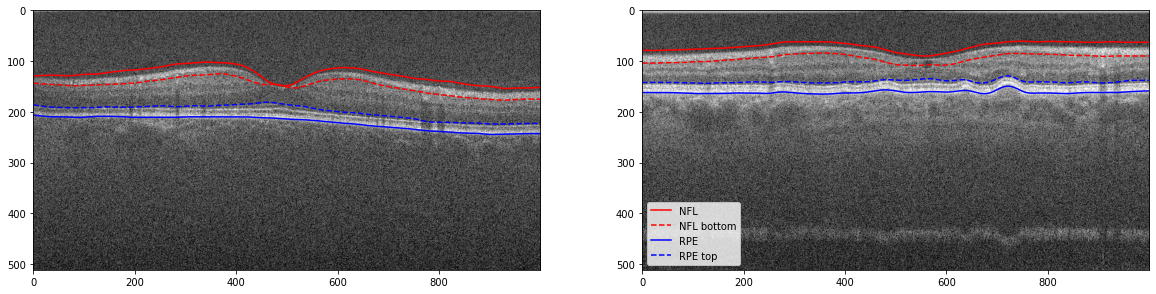

In [304]:
def first_layer(im):
    n,m = im.shape
    position=[]
    for i in range(m):
        ascan=im[:,i]
        max_pos = np.argmax(ascan)
        position.append(max_pos)
    return(position)

def first_layer_bottom(im,layer):
    n,m = im.shape
    position=[]
    for i in range(m):
        ascan=im[:,i]
        ascan=ascan[int(layer[i])+1:]
        max_pos = np.argmin(ascan)+int(layer[i])
        position.append(max_pos)
    return(position)

def last_layer(im):
    n,m = im.shape
    position=[]
    for i in range(m):
        ascan=im[:,i]
        ascan=ascan[::-1]
        max_pos = np.argmax(ascan)
        position.append(n-max_pos)
    return(position)

def last_layer_top(im,layer):
    n,m = im.shape
    position=[]
    for i in range(m):
        ascan=im[:,i]
        ascan=ascan[:int(layer[i])-1]
        ascan=ascan[::-1]
        max_pos = np.argmin(ascan)
        position.append(int(layer[i])-max_pos)
    return(position)

def jump_filter(layer,jump=10,offset=1):
    new_layer=layer
    for i in range(offset,len(layer)):
        if( np.abs(new_layer[i-offset]-new_layer[i])>jump ):
            new_layer[i]=new_layer[i-offset]
    return(new_layer)

def golay_filter(layer):
    layer_smooth=signal.savgol_filter(layer,polyorder=2, window_length=51, deriv=0, delta=10.0, axis=- 1, mode='interp', cval=0.0)
    return(layer_smooth)


def layers(i_closing):
	f_l=first_layer(i_closing)
	f_l=jump_filter(f_l,jump=10,offset=1)
	f_l=golay_filter(f_l)

	b_f_l=first_layer_bottom(i_closing,f_l)
	b_f_l=jump_filter(b_f_l,jump=10,offset=1)
	b_f_l=golay_filter(b_f_l)

	l_l=last_layer(i_closing)
	l_l=jump_filter(l_l,jump=10,offset=1)
	l_l=golay_filter(l_l)

	t_l_l=last_layer_top(i_closing,l_l)
	t_l_l=jump_filter(t_l_l,jump=10,offset=1)
	t_l_l=golay_filter(t_l_l)
	return(f_l,l_l,b_f_l,t_l_l)
# np.where(layer==None)

plt.figure(figsize=(20,5))

i_closing=mask(image_normal)
f_l,l_l,b_f_l,t_l_l=layers(i_closing)
plt.subplot(121)
plt.imshow(image_normal,cmap='gray')
plt.plot(f_l+5,'r',label="NFL")
plt.plot(b_f_l+5,'r--',label="NFL bottom")
plt.plot(l_l+5,'b',label="RPE")
plt.plot(t_l_l+5,'b--',label="RPE top")

i_closing=mask(image_amd)
f_l,l_l,b_f_l,t_l_l=layers(i_closing)
plt.subplot(122)
plt.imshow(image_amd,cmap='gray')
plt.plot(f_l+5,'r',label="NFL")
plt.plot(b_f_l+5,'r--',label="NFL bottom")
plt.plot(l_l+5,'b',label="RPE")
plt.plot(t_l_l+5,'b--',label="RPE top")
plt.legend()

## Quantifiers

Text(0.5, 1.0, 'AMD NSR')

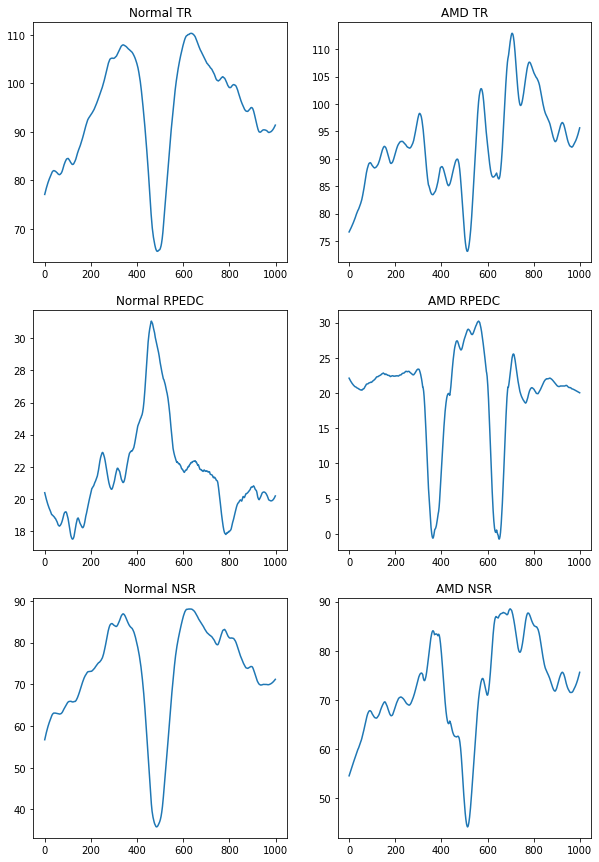

In [265]:
def TR_layers(layers):
    f_l,l_l,b_f_l,t_l_l=layers
    return(l_l-f_l)

def RPEDC_layers(layers):
    f_l,l_l,b_f_l,t_l_l=layers
    return(l_l-t_l_l)

def NSR_layers(layers):
    f_l,l_l,b_f_l,t_l_l=layers
    return(t_l_l-f_l)

plt.figure(figsize=(10,15))
i_closing=mask(image_normal)
layers_=layers(i_closing)
plt.subplot(321)
plt.plot(TR_layers(layers_))
plt.title("Normal TR")
plt.subplot(323)
plt.plot(RPEDC_layers(layers_))
plt.title("Normal RPEDC")
plt.subplot(325)
plt.plot(NSR_layers(layers_))
plt.title("Normal NSR")

i_closing=mask(image_amd)
layers_=layers(i_closing)
plt.subplot(322)
plt.plot(TR_layers(layers_))
plt.title("AMD TR")
plt.subplot(324)
plt.plot(RPEDC_layers(layers_))
plt.title("AMD RPEDC")
plt.subplot(326)
plt.plot(NSR_layers(layers_))
plt.title("AMD NSR")



## Statistical Analysis

In [266]:
TR_normal=[]
RPEDC_normal=[]
NSR_normal=[]

for f in files_normal:
	image_normal = mpimg.imread(os.path.join(path_normal,f))
	i_closing=mask(image_normal)
	layers_=layers(i_closing)
	TR_normal.append(TR_layers(layers_))
	RPEDC_normal.append(RPEDC_layers(layers_))
	NSR_normal.append(NSR_layers(layers_))
  
TR_amd=[]
RPEDC_amd=[]
NSR_amd=[]

for f in files_amd:
	image_amd = mpimg.imread(os.path.join(path_amd,f))
	i_closing=mask(image_amd)
	layers_=layers(i_closing)
	TR_amd.append(TR_layers(layers_))
	RPEDC_amd.append(RPEDC_layers(layers_))
	NSR_amd.append(NSR_layers(layers_))

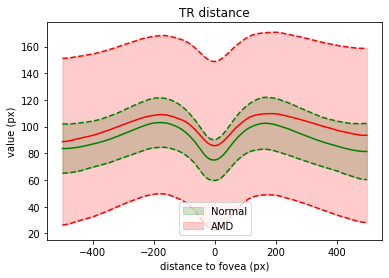

In [296]:
def var_to_stat(var):
	var=np.array(var)
	mean=np.mean(var,axis=0)
	std=np.std(var,axis=0)
	return(mean,std)

m,s=var_to_stat(TR_normal)
x=np.arange(-len(m)/2,len(m)/2)
plt.plot(x, m, "g")
plt.plot(x, m-s, "g--")
plt.plot(x, m+s, "g--")
plt.fill_between(x, m-s, m+s, color="green",alpha=0.2,label="Normal")

m,s=var_to_stat(TR_amd)
plt.plot(x, m, "r")
plt.plot(x, m-s, "r--")
plt.plot(x, m+s, "r--")
plt.fill_between(x, m-s, m+s, color="red",alpha=0.2,label="AMD")

plt.title("TR distance")
plt.xlabel('distance to fovea (px)')
plt.ylabel('value (px)')
plt.legend()

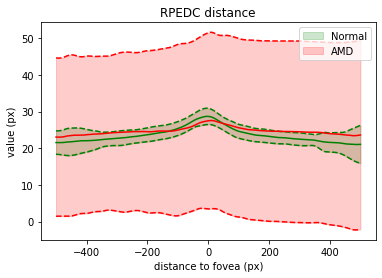

In [297]:
m,s=var_to_stat(RPEDC_normal)
x=np.arange(-len(m)/2,len(m)/2)
plt.plot(x, m, "g")
plt.plot(x, m-s, "g--")
plt.plot(x, m+s, "g--")
plt.fill_between(x, m-s, m+s, color="green",alpha=0.2,label="Normal")

m,s=var_to_stat(RPEDC_amd)
plt.plot(x, m, "r")
plt.plot(x, m-s, "r--")
plt.plot(x, m+s, "r--")
plt.fill_between(x, m-s, m+s, color="red",alpha=0.2,label="AMD")

plt.title("RPEDC distance")
plt.xlabel('distance to fovea (px)')
plt.ylabel('value (px)')
plt.legend()


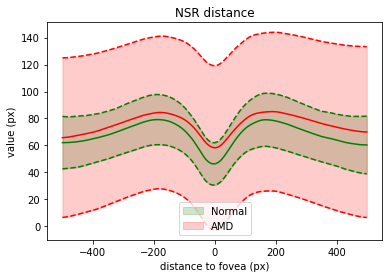

In [298]:
m,s=var_to_stat(NSR_normal)
x=np.arange(-len(m)/2,len(m)/2)
plt.plot(x, m, "g")
plt.plot(x, m-s, "g--")
plt.plot(x, m+s, "g--")
plt.fill_between(x, m-s, m+s, color="green",alpha=0.2,label="Normal")

m,s=var_to_stat(NSR_amd)
plt.plot(x, m, "r")
plt.plot(x, m-s, "r--")
plt.plot(x, m+s, "r--")
plt.fill_between(x, m-s, m+s, color="red",alpha=0.2,label="AMD")

plt.title("NSR distance")
plt.xlabel('distance to fovea (px)')
plt.ylabel('value (px)')
plt.legend()
